# Train-and-Permute-MNIST-MLP

In [6]:
import os
import sys

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
import torchvision
import torchvision.transforms as T

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# setup

In [8]:
os.makedirs('./mlps3', exist_ok=True)
def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), 'mlps3/%s.pt' % i)

def load_model(model, i):
    sd = torch.load('mlps3/%s.pt' % i)
    model.load_state_dict(sd)

In [9]:
# # write ffcv files (only needs to be run once)
# import torchvision
# from ffcv.fields import IntField, RGBImageField
# from ffcv.writer import DatasetWriter

# transform = lambda img: img.convert('RGB')
# train_dset = torchvision.datasets.MNIST(root='/tmp', download=True, train=True, transform=transform)
# test_dset = torchvision.datasets.MNIST(root='/tmp', download=True, train=False, transform=transform)

# datasets = { 
#     'train': train_dset,
#     'test': test_dset,
# }

# for (name, ds) in datasets.items():
#     writer = DatasetWriter(f'/tmp/mnist_{name}.beton', {
#         'image': RGBImageField(),
#         'label': IntField()
#     })  
#     writer.from_indexed_dataset(ds)

In [10]:
from ffcv.fields import IntField, RGBImageField
from ffcv.fields.decoders import IntDecoder, SimpleRGBImageDecoder
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import RandomHorizontalFlip, Cutout, \
    RandomTranslate, Convert, ToDevice, ToTensor, ToTorchImage
from ffcv.transforms.common import Squeeze

MNIST_MEAN = [33.32]
MNIST_STD = [78.58]
normalize = T.Normalize(np.array(MNIST_MEAN), np.array(MNIST_STD))

## fast FFCV data loaders
device = 'cuda:0' 
label_pipeline = [IntDecoder(), ToTensor(), ToDevice(device), Squeeze()]
pre_p = [SimpleRGBImageDecoder()]
post_p = [
    ToTensor(),
#     ToDevice(device, non_blocking=True), # this is faster but turns out to create a gpu-memory leak...
    ToTorchImage(),
    Convert(torch.float16),
    normalize,
]
train_loader = train_noaug_loader = Loader(f'/tmp/mnist_train.beton',
                     batch_size=2000,
                     num_workers=8,
                     order=OrderOption.RANDOM,
                     drop_last=False,
                     pipelines={'image': pre_p+post_p,
                                'label': label_pipeline})
test_loader = Loader(f'/tmp/mnist_test.beton',
                     batch_size=2000,
                     num_workers=8,
                     order=OrderOption.SEQUENTIAL,
                     drop_last=False,
                     pipelines={'image': pre_p+post_p,
                                'label': label_pipeline})

In [11]:
# evaluates accuracy
def evaluate(model, loader=test_loader):
    model.eval()
    correct = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
    return correct

# evaluates acc and loss
def evaluate2(model, loader=test_loader):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            total += len(labels)
            loss = F.cross_entropy(outputs, labels.cuda())
            losses.append(loss.item())
    return correct / total, np.array(losses).mean()

def full_eval1(model):
    tr_acc, tr_loss = evaluate2(model, loader=train_noaug_loader)
    te_acc, te_loss = evaluate2(model, loader=test_loader)
    return '%.2f, %.3f, %.2f, %.3f' % (100*tr_acc, tr_loss, 100*te_acc, te_loss)

def full_eval(model):
    tr_acc, tr_loss = evaluate2(model, loader=train_noaug_loader)
    te_acc, te_loss = evaluate2(model, loader=test_loader)
    return (100*tr_acc, tr_loss, 100*te_acc, te_loss)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class NormMLP(nn.Module):
    def __init__(self, h=128, layers=3):
        super().__init__()
        self.fc1 = nn.Linear(28*28, h, bias=False)
        self.bn1 = nn.BatchNorm1d(h)
        mid_layers = []
        for _ in range(layers):
            mid_layers.extend([
                nn.Linear(h, h, bias=False),
                nn.BatchNorm1d(h),
                nn.ReLU(),
            ])
        self.layers = nn.Sequential(*mid_layers)
        self.fc2 = nn.Linear(h, 10)

    def forward(self, x):
        if x.size(1) == 3:
            x = x.mean(1, keepdim=True)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.layers(x)
        x = self.fc2(x)
        return x
    
class MLP(nn.Module):
    def __init__(self, h=128, layers=3):
        super().__init__()
        self.fc1 = nn.Linear(28*28, h)
        mid_layers = []
        for _ in range(layers):
            mid_layers.extend([nn.Linear(h, h), nn.ReLU()])
        self.layers = nn.Sequential(*mid_layers)
        self.fc2 = nn.Linear(h, 10)

    def forward(self, x):
        if x.size(1) == 3:
            x = x.mean(1, keepdim=True)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.layers(x)
        x = self.fc2(x)
        return x
    
def fuse_fc_bn(fc, bn):
    fused = nn.Linear(fc.in_features, fc.out_features)
    # setting weights
    w_fc = fc.weight.clone()
    bn_std = (bn.eps + bn.running_var).sqrt()
    gamma = bn.weight / bn_std
    fused.weight.data = (w_fc * gamma.reshape(-1, 1))
    # setting bias
    b_fc = fc.bias if fc.bias is not None else torch.zeros_like(bn.bias)
    beta = bn.bias + gamma * (-bn.running_mean + b_fc)
    fused.bias.data = beta
    return fused
    
def fuse_net(net):
    assert isinstance(net, NormMLP)
    layers = len(net.layers)//3
    h = len(net.fc1.weight)
    net1 = MLP(h, layers)
    net1.fc1 = fuse_fc_bn(net.fc1, net.bn1)
    for i in range(layers):
        net1.layers[2*i] = fuse_fc_bn(net.layers[3*i], net.layers[3*i+1])
    net1.fc2.load_state_dict(net.fc2.state_dict())
    return net1

## Train and save two models

In [13]:
def train(save_key, layers=5, h=512):
    model = NormMLP(h=h, layers=layers).cuda()

    optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9)

    EPOCHS = 50
    ne_iters = len(train_loader)
    lr_schedule = np.interp(np.arange(1+EPOCHS*ne_iters), [0, 5*ne_iters, EPOCHS*ne_iters], [0, 1, 0])
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

    scaler = GradScaler()
    loss_fn = CrossEntropyLoss()

    for _ in tqdm(range(EPOCHS)):
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad(set_to_none=True)
            with autocast():
                outputs = model(inputs.cuda())
                loss = loss_fn(outputs, labels.cuda())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
    
    print(evaluate(model))
    save_model(model, save_key)

In [14]:
# for layers in range(1, 51):
#     h = 128
#     train('mlp_e50_l%d_h%d_v1' % (layers, h), layers=layers, h=h)
#     train('mlp_e50_l%d_h%d_v2' % (layers, h), layers=layers, h=h)

### matching code

In [15]:
# given two networks net0, net1 which each output a feature map of shape NxCxWxH
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the outputs of the two networks
def run_corr_matrix(net0, net1, epochs=1, loader=train_loader):
    n = epochs*len(loader)
    mean0 = mean1 = std0 = std1 = None
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for _ in range(epochs):
            for i, (images, _) in enumerate(tqdm(loader)):
                img_t = images.float().cuda()
                out0 = net0(img_t)
                out0 = out0.reshape(out0.shape[0], out0.shape[1], -1).permute(0, 2, 1)
                out0 = out0.reshape(-1, out0.shape[2]).double()

                out1 = net1(img_t)
                out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
                out1 = out1.reshape(-1, out1.shape[2]).double()

                mean0_b = out0.mean(dim=0)
                mean1_b = out1.mean(dim=0)
                std0_b = out0.std(dim=0)
                std1_b = out1.std(dim=0)
                outer_b = (out0.T @ out1) / out0.shape[0]

                if i == 0:
                    mean0 = torch.zeros_like(mean0_b)
                    mean1 = torch.zeros_like(mean1_b)
                    std0 = torch.zeros_like(std0_b)
                    std1 = torch.zeros_like(std1_b)
                    outer = torch.zeros_like(outer_b)
                mean0 += mean0_b / n
                mean1 += mean1_b / n
                std0 += std0_b / n
                std1 += std1_b / n
                outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    corr = cov / (torch.outer(std0, std1) + 1e-4)
    return corr

In [16]:
def get_layer_perm1(corr_mtx):
    corr_mtx_a = corr_mtx.cpu().numpy()
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
    assert (row_ind == np.arange(len(corr_mtx_a))).all()
    perm_map = torch.tensor(col_ind).long()
    return perm_map

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_layer_perm1(corr_mtx)

# Find neuron-permutation for each layer

In [17]:
# for layers in range(1, 51):
for layers in [10]:

    v1, v2 = 1, 2
    h = 128

    model0 = NormMLP(h=h, layers=layers).cuda()
    model1 = NormMLP(h=h, layers=layers).cuda()
    load_model(model0, 'mlp_e50_l%d_h%d_v%d' % (layers, h, v1))
    load_model(model1, 'mlp_e50_l%d_h%d_v%d'% (layers, h, v2))
#     print(evaluate(model0), evaluate(model1))

    class Subnet(nn.Module):
        def __init__(self, model, layer_i):
            super().__init__()
            self.model = model
            self.layer_i = layer_i
        def forward(self, x):
            if x.size(1) == 3:
                x = x.mean(1, keepdim=True)
            x = x.reshape(x.size(0), -1)
            x = F.relu(self.model.bn1(self.model.fc1(x)))
            x = self.model.layers[:3*self.layer_i](x)
            return x

    perm_map = get_layer_perm(Subnet(model0, layer_i=0), Subnet(model1, layer_i=0))
    fc = model1.fc1
    w_list = [fc.weight]
    bn = model1.bn1
    w_list.extend([bn.weight,
                    bn.bias,
                    bn.running_mean,
                    bn.running_var])
    for w in w_list:
        w.data = w[perm_map]
    for w in [model1.layers[0].weight]:
        w.data = w.data[:, perm_map]

    ########

    for i in range(layers):
        perm_map = get_layer_perm(Subnet(model0, layer_i=i+1), Subnet(model1, layer_i=i+1))
        fc = model1.layers[3*i]
        w_list = [fc.weight]
        bn = model1.layers[3*i+1]
        w_list.extend([bn.weight,
                        bn.bias,
                        bn.running_mean,
                        bn.running_var])
        for w in w_list:
            w.data = w[perm_map]
        if i < layers-1:
            for w in [model1.layers[3*(i+1)].weight]:
                w.data = w[:, perm_map]
    w = model1.fc2.weight
    w.data = w[:, perm_map]

    save_model(model1, 'mlp_e50_l%d_h%d_v%d_perm%d' % (layers, h, v2, v1))

KeyboardInterrupt: 

In [14]:
# h = 128
# v1, v2 = 1, 2

# for layers in tqdm(range(1, 51)):
#     pre = 'mlp_e50_l%d_h%d' % (layers, h)

#     model0 = NormMLP(h, layers).cuda()
#     model1 = NormMLP(h, layers).cuda()
#     load_model(model0, '%s_v%d' % (pre, v1))
#     load_model(model1, '%s_v%d_perm%d' % (pre, v2, v1))

#     model0 = fuse_net(model0)
#     save_model(model0, '%s_v%d_fused' % (pre, v1))
#     model1 = fuse_net(model1)
#     save_model(model1, '%s_v%d_perm%d_fused' % (pre, v2, v1))

In [15]:
# for layers in tqdm(range(1, 51)):
#     pre = 'mlp_e50_l%d_h%d' % (layers, h)
#     k2 = '%s_v%d' % (pre, v2)
#     model1 = NormMLP(h, layers)
#     load_model(model1, k2)
#     model1 = fuse_net(model1)
#     save_model(model1, k2+'_fused')

## Evaluate the interpolated network

In [18]:
def mix_weights(model, alpha, key0, key1, premodel=None):
    sd0 = torch.load('mlps3/%s.pt' % key0)
    sd1 = torch.load('mlps3/%s.pt' % key1)
    sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
                for k in sd0.keys()}
    model.load_state_dict(sd_alpha)

# use the train loader with data augmentation as this gives better results
def reset_bn_stats(model, epochs=2, loader=train_loader):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if isinstance(m, nn.modules.batchnorm._BatchNorm):
            m.momentum = None # use simple average
            m.reset_running_stats()
    # run a single train epoch with augmentations to recalc stats
    model.train()
    for _ in range(epochs):
        with torch.no_grad(), autocast():
            for images, _ in loader:
                output = model(images.cuda())
    model.eval()

In [19]:
layers = 10
h = 128
pre = 'mlp_e50_l%d_h%d' % (layers, h)
v1, v2 = 1, 2
k1 = '%s_v%d' % (pre, v1)
k2 = '%s_v%d_perm%d' % (pre, v2, v1)

model0 = NormMLP(h, layers).cuda()
model1 = NormMLP(h, layers).cuda()
load_model(model0, k1)
load_model(model1, k2)
print('(α=0.0)', full_eval(model0))
print('(α=1.0)', full_eval(model1))

model_a = NormMLP(h, layers).cuda()
mix_weights(model_a, 0.5, k1, k2)
print('(α=0.5 permuted)', full_eval(model_a))

reset_bn_stats(model_a)
print('(α=0.5 permuted corrected)', full_eval(model_a))

(α=0.0) (100.0, 0.00011900452785387946, 98.29, 0.08788808435201645)
(α=1.0) (100.0, 0.00011220618301498083, 98.21, 0.09164906963706017)
(α=0.5 permuted) (80.55666666666667, 0.6879887024561564, 80.69, 0.6824256539344787)
(α=0.5 permuted corrected) (95.86166666666666, 0.20888673563798268, 95.49, 0.23867447972297667)


In [754]:
class ResetLayer(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.bn = nn.BatchNorm1d(len(layer.weight))
        self.rescale = False
        
    def set_stats(self, goal_mean, goal_var):
        self.bn.bias.data = goal_mean
        goal_std = (goal_var + 1e-7).sqrt()
        self.bn.weight.data = goal_std
        
    def forward(self, x):
        x = self.layer(x)
        x1 = self.bn(x)
        return x1 if self.rescale else x
    
def fuse_reset(layer):
    return fuse_fc_bn(layer.layer, layer.bn)

def make_tracked_net(net):
    net1 = MLP(layers=len(net.layers)//2, h=net.fc1.out_features)
    net1.load_state_dict(net.state_dict())
    net1.fc1 = ResetLayer(net1.fc1)
    for i, layer in enumerate(net.layers):
        if isinstance(layer, nn.Linear):
            net1.layers[i] = ResetLayer(layer)
#     net1.fc2 = ResetLayer(net1.fc2)
    return net1.cuda().eval()

def fuse_tracked_net(net):
    net1 = MLP(layers=len(net.layers)//2, h=net.fc1.layer.out_features)
    net1.fc1 = fuse_reset(net.fc1)
    for i, layer in enumerate(net.layers):
        if isinstance(layer, ResetLayer):
            net1.layers[i] = fuse_reset(layer)
    net1.fc2.load_state_dict(net.fc2.state_dict())
    return net1.cuda().eval()

def forward_pass_correction(wrap_a, model0, model1, alpha=0.5):
    ## calculate the statistics of every hidden unit in the endpoint networks
    ## this is done practically using PyTorch BatchNorm2d layers.
    wrap0 = make_tracked_net(model0)
    wrap1 = make_tracked_net(model1)
    reset_bn_stats(wrap0)
    reset_bn_stats(wrap1)
    
    ## set the goal mean/std in added bns of interpolated network, and turn batch renormalization on
    for m_a, m0, m1 in zip(wrap_a.modules(), wrap0.modules(), wrap1.modules()):
        if not isinstance(m0, ResetLayer):
            continue
        # get goal statistics -- interpolate the mean and std of parent networks
        mu0 = m0.bn.running_mean
        mu1 = m1.bn.running_mean
        goal_mean = (1 - alpha) * mu0 + alpha * mu1
        var0 = m0.bn.running_var
        var1 = m1.bn.running_var
        goal_var = ((1 - alpha) * var0.sqrt() + alpha * var1.sqrt()).square()
        # set these in the interpolated bn controller
        m_a.set_stats(goal_mean, goal_var)
        # turn rescaling on
        m_a.rescale = True
    reset_bn_stats(wrap_a, epochs=3)

In [755]:
layers = 35
h = 128
pre = 'mlp_e50_l%d_h%d' % (layers, h)
v1, v2 = 1, 2
k1 = '%s_v%d_fused' % (pre, v1)
k2 = '%s_v%d_perm%d_fused' % (pre, v2, v1)

model0 = MLP(h, layers).cuda()
model1 = MLP(h, layers).cuda()
load_model(model0, k1)
load_model(model1, k2)
print('(α=0.0)', full_eval(model0))
print('(α=1.0)', full_eval(model1))

model_a = MLP(h, layers).cuda()
mix_weights(model_a, 0.5, k1, k2)
print('(α=0.5 permuted)', full_eval(model_a))

## calculate the statistics of every hidden unit in the endpoint networks
## this is done practically using PyTorch BatchNorm layers.
wrap_a = make_tracked_net(model_a)
forward_pass_correction(wrap_a, model0, model1, 0.5)
print('(α=0.5 permuted+corrected)', full_eval(wrap_a))

(α=0.0) (99.85333333333334, 0.005897032228919367, 97.76, 0.12175396233797073)
(α=1.0) (99.83, 0.007358756094860534, 97.78, 0.11046934127807617)
(α=0.5 permuted) (9.915000000000001, 3.1354936599731444, 10.09, 3.125978183746338)
(α=0.5 permuted+corrected) (87.49666666666667, 0.82353861729304, 86.92999999999999, 0.8572109460830688)


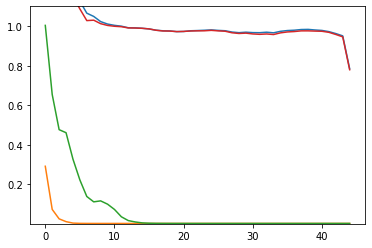

In [457]:
layers = 45
h = 128
pre = 'mlp_e50_l%d_h%d' % (layers, h)
v1, v2 = 1, 2
k1 = '%s_v%d_fused' % (pre, v1)
k2 = '%s_v%d_perm%d_fused' % (pre, v2, v1)

model0 = MLP(h, layers).cuda()
model1 = MLP(h, layers).cuda()
load_model(model0, k1)
load_model(model1, k2)

model_a = MLP(h, layers).cuda()
mix_weights(model_a, 0.5, k1, '%s_v%d_fused' % (pre, v2))
wrap_b = make_tracked_net(model_a)
reset_bn_stats(wrap_b)

model_a = MLP(h, layers).cuda()
mix_weights(model_a, 0.5, k1, k2)
wrap_c = make_tracked_net(model_a)
reset_bn_stats(wrap_c)

model_a = MLP(h, layers).cuda()
mix_weights(model_a, 0.5, k1, k2)
wrap_a = make_tracked_net(model_a)
forward_pass_correction(wrap_a, model0, model1)
wrap_d = make_tracked_net(fuse_tracked_net(wrap_a))
reset_bn_stats(wrap_d)

wrap0 = make_tracked_net(model0)
wrap1 = make_tracked_net(model1)
reset_bn_stats(wrap0)
reset_bn_stats(wrap1)


def get_layerwise_var(wrap):
    vv = []
    for ii in range(len(wrap.layers)//2):
        vv.append(wrap.layers[2*ii].bn.running_var.mean().item())
    return vv
vv0 = get_layerwise_var(wrap0)
vv1 = get_layerwise_var(wrap1)
vvb = get_layerwise_var(wrap_b)
vvc = get_layerwise_var(wrap_c)
vvd = get_layerwise_var(wrap_d)
vv01 = (np.array(vv0) + np.array(vv1))/2

rrb = np.array(vvb) / vv01
rrc = np.array(vvc) / vv01
rrd = np.array(vvd) / vv01

# plt.plot(rrb)
# plt.plot(rrc)
# plt.plot(rrd)

plt.plot(vv01)
plt.plot(vvb)
plt.plot(vvc)
plt.plot(vvd)

# plt.yscale('log')
plt.ylim([1e-7, 1.1])
plt.show()

In [451]:
obj = {
    'v1': vv0,
    'v2': vv1,
    'vanilla': vvb,
    'permuted': vvc,
    'permuted_renorm': vvd,
}

In [452]:
torch.save(obj, 'layerwise_var_%s.pt' % pre)

## Closed-Form

In [782]:
def run_stats(net0, net1, loader=train_loader):
    with torch.no_grad():
        net0.eval()
        net1.eval()
        
        mean0_l = []
        mean1_l = []
        var0_l = []
        var1_l = []
        cov_l = []
        for images, _ in loader:
            img_t = images.float().cuda()
            out0 = net0(img_t)
            out0 = out0.reshape(out0.shape[0], out0.shape[1], -1).permute(0, 2, 1)
            out0 = out0.reshape(-1, out0.shape[2]).double()

            out1 = net1(img_t)
            out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
            out1 = out1.reshape(-1, out1.shape[2]).double()

            mean0 = out0.mean(0)
            mean1 = out1.mean(0)
            var0 = out0.var(0)
            var1 = out1.var(0)
            cov = ((out0 - mean0) * (out1 - mean1)).mean(0)
            
            mean0_l.append(mean0)
            mean1_l.append(mean1)
            var0_l.append(var0)
            var1_l.append(var1)
            cov_l.append(cov)
            
        mean0 = torch.stack(mean0_l).mean(0)
        mean1 = torch.stack(mean1_l).mean(0)
        var0 = torch.stack(var0_l).mean(0)
        var1 = torch.stack(var1_l).mean(0)
        cov = torch.stack(cov_l).mean(0)

    return mean0.float(), mean1.float(), var0.float(), var1.float(), cov.float()

class Subnet(nn.Module):
    def __init__(self, model, k):
        super().__init__()
        self.fc1 = model.fc1
        self.layers = model.layers[:2*k-1] if k > 0 else None
    def forward(self, x):
        if x.size(1) == 3:
            x = x.mean(1, keepdim=True)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        if self.layers:
            x = F.relu(x)
            x = self.layers(x)
        return x

def closed_form_correction(wrap_a, model0, model1, alpha=0.5):
    for i in range(0, layers+1):
        mean0, mean1, var0, var1, cov = run_stats(Subnet(model0, i), Subnet(model1, i))
        inter_mean = (1 - alpha)*mean0 + alpha*mean1
        inter_var = (1 - alpha)**2*var0 + 2*alpha*(1 - alpha) * cov + alpha**2*var1
        goal_mean = inter_mean
        goal_var = ((1 - alpha)*var0.sqrt() + alpha*var1.sqrt()).square()

        if i == 0:
            reset = wrap_a.fc1
        else:
            reset = wrap_a.layers[2*(i-1)]
        reset.bn.running_mean.data = inter_mean.float()
        reset.bn.running_var.data = inter_var.float()
        reset.set_stats(goal_mean.float(), goal_var.float())
        reset.rescale = True

In [757]:
layers = 10
h = 128
pre = 'mlp_e50_l%d_h%d' % (layers, h)
v1, v2 = 1, 2
k1 = '%s_v%d_fused' % (pre, v1)
k2 = '%s_v%d_perm%d_fused' % (pre, v2, v1)

model0 = MLP(h, layers).cuda()
model1 = MLP(h, layers).cuda()
load_model(model0, k1)
load_model(model1, k2)
print('(α=0.0)', full_eval(model0))
print('(α=1.0)', full_eval(model1))

model_a = MLP(h, layers).cuda()
mix_weights(model_a, 0.5, k1, k2)
print('(α=0.5 permuted)', full_eval(model_a))

wrap_a = make_tracked_net(model_a)
forward_pass_correction(wrap_a, model0, model1)
print('(α=0.5 permuted corrected)', full_eval(wrap_a))

wrap_b = make_tracked_net(model_a)
closed_form_correction(wrap_b, model0, model1)
print('(α=0.5 permuted corrected by formula)', full_eval(wrap_b))

(α=0.0) (100.0, 0.00011900206397209937, 98.28, 0.08788619413971901)
(α=1.0) (100.0, 0.00011223381782959526, 98.21, 0.09160843640565872)
(α=0.5 permuted) (81.26, 0.6684819360574087, 81.17999999999999, 0.6651139259338379)
(α=0.5 permuted corrected) (95.81, 0.21187422821919125, 95.46, 0.24068381786346435)
(α=0.5 permuted corrected by formula) (95.32333333333334, 0.2501784438888232, 94.83, 0.2895711809396744)


In [786]:
layers = 10
h = 128
pre = 'mlp_e50_l%d_h%d' % (layers, h)
v1, v2 = 1, 2
k1 = '%s_v%d_fused' % (pre, v1)
k2 = '%s_v%d_perm%d_fused' % (pre, v2, v1)

model0 = MLP(h, layers).cuda()
model1 = MLP(h, layers).cuda()
load_model(model0, k1)
load_model(model1, k2)

model_a = MLP(h, layers).cuda()
mix_weights(model_a, 0.5, k1, k2)
wrap_a = make_tracked_net(model_a)
forward_pass_correction(wrap_a, model0, model1)
print('(α=0.5 permuted corrected)', full_eval(wrap_a))
vv1 = wrap_a.fc1.bn.running_var
# vv1 = wrap_a.layers[0].bn.running_var

(α=0.5 permuted corrected) (95.80499999999999, 0.2118744303782781, 95.46, 0.2407013386487961)


In [787]:
wrap_b = make_tracked_net(model_a)
closed_form_correction(wrap_b, model0, model1)
vv2 = wrap_b.fc1.bn.running_var
# vv2 = wrap_b.layers[0].bn.running_var

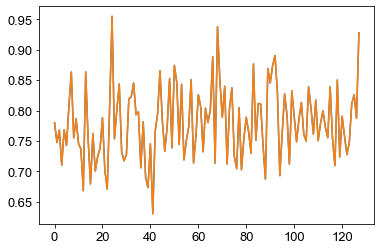

In [788]:
plt.plot(vv1.tolist())
plt.plot(vv2.tolist())
plt.show()

In [857]:
def run_stats(net0, net1, loader=train_loader):
    with torch.no_grad():
        net0.eval()
        net1.eval()
        
        mean0_l = []
        mean1_l = []
        var0_l = []
        var1_l = []
        cov_l = []
        for images, _ in loader:
            img_t = images.float().cuda()
            out0 = net0(img_t)
            out0 = out0.reshape(out0.shape[0], out0.shape[1], -1).permute(0, 2, 1)
            out0 = out0.reshape(-1, out0.shape[2]).double()

            out1 = net1(img_t)
            out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
            out1 = out1.reshape(-1, out1.shape[2]).double()

            mean0 = out0.mean(0)
            mean1 = out1.mean(0)
            var0 = out0.var(0)
            var1 = out1.var(0)
            cov = ((out0 - mean0) * (out1 - mean1)).mean(0)
            
            mean0_l.append(mean0)
            mean1_l.append(mean1)
            var0_l.append(var0)
            var1_l.append(var1)
            cov_l.append(cov)
            
        mean0 = torch.stack(mean0_l).mean(0)
        mean1 = torch.stack(mean1_l).mean(0)
        var0 = torch.stack(var0_l).mean(0)
        var1 = torch.stack(var1_l).mean(0)
        cov = torch.stack(cov_l).mean(0)

    return mean0.float(), mean1.float(), var0.float(), var1.float(), cov.float()

class Subnet(nn.Module):
    def __init__(self, model, k):
        super().__init__()
        self.fc1 = model.fc1
        self.layers = model.layers[:2*k-1] if k > 0 else None
    def forward(self, x):
        if x.size(1) == 3:
            x = x.mean(1, keepdim=True)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        if self.layers:
            x = F.relu(x)
            x = self.layers(x)
        return x

i = 0
alpha = 0.5

mean0, mean1, var0, var1, cov = run_stats(Subnet(model0, i), Subnet(model1, i))

inter_mean = (1 - alpha) * mean0 + alpha * mean1
inter_var = (1 - alpha)**2 * var0 + 2 * alpha * (1 - alpha) * cov + alpha**2 * var1
goal_mean = inter_mean
goal_var = ((1 - alpha) * var0.sqrt() + alpha * var1.sqrt()).square()

In [852]:
import scipy.stats

In [859]:
vv1 = wrap_a.fc1.bn.running_var.data
vv2 = inter_var

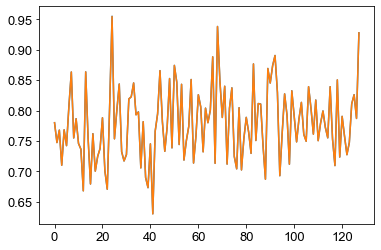

In [860]:
plt.plot(vv1.tolist())
plt.plot(vv2.tolist())
plt.show()

## Industrial eval

In [510]:
stats = {}
for layers in tqdm(range(15, 20)):
    h = 128
    pre = 'mlp_e50_l%d_h%d' % (layers, h)
    v1, v2 = 1, 2
    s = {}

    model0 = MLP(h=h, layers=layers).cuda()
    model1 = MLP(h=h, layers=layers).cuda()
    model_a = MLP(h=h, layers=layers).cuda()
    load_model(model0, '%s_v%d_fused' % (pre, v1))
    load_model(model1, '%s_v%d_perm%d_fused' % (pre, v2, v1))
    s['v1'] = full_eval(model0)
    s['v2'] = full_eval(model1)
    
    mix_weights(model_a, 0.5, '%s_v%d_fused' % (pre, v1), '%s_v%d_fused' % (pre, v2))
    s['vanilla'] = full_eval(model_a)
    
    mix_weights(model_a, 0.5, '%s_v%d_fused' % (pre, v1), '%s_v%d_perm%d_fused' % (pre, v2, v1))
    s['permute'] = full_eval(model_a)
    
    wrap_a = make_tracked_net(model_a)
    forward_pass_correction(wrap_a, model0, model1, 0.5)
    s['permute_correct'] = full_eval(wrap_a)
    
    wrap_a = make_tracked_net(model_a)
    closed_form_correction(wrap_a, model0, model1, 0.5)
    s['permute_correct_formula'] = full_eval(wrap_a)
    
    stats[pre] = s

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.35s/it]


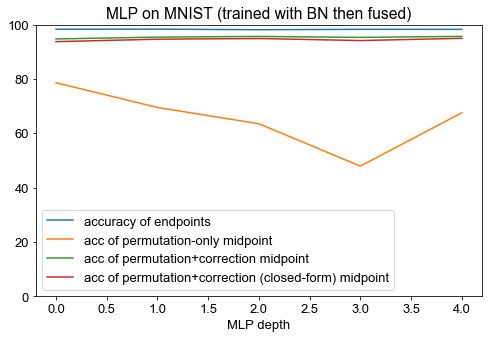

In [511]:
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.size"] = "13"
plt.figure(figsize=(8, 5))

ii = 2
yy0a = [s['v1'][ii] for s in stats.values()]
yy0b = [s['v2'][ii] for s in stats.values()]
yy0 = (np.array(yy0a) + np.array(yy0b)) / 2
yy1 = [s['permute'][ii] for s in stats.values()]
yy2 = [s['permute_correct'][ii] for s in stats.values()]
yy3 = [s['permute_correct_formula'][ii] for s in stats.values()]
plt.plot(yy0, label='accuracy of endpoints')
plt.plot(yy1, label='acc of permutation-only midpoint')
plt.plot(yy2, label='acc of permutation+correction midpoint')
plt.plot(yy3, label='acc of permutation+correction (closed-form) midpoint')
plt.ylim([0, 100])
# plt.ylim([90, 100])
plt.xlabel('MLP depth')
plt.title('MLP on MNIST (trained with BN then fused)')
plt.legend()
plt.show()

In [507]:
# torch.save(stats, 'mlp_barriers_layers1to50.pt')